# HIL testing

In the [previous part](workflow03.md) of this series we designed a control algorithm for the system and evaluated it with a fairly detailed simulation, including sensor and actuator models resolved to I/O voltage levels.
Finally, we used the [`codegen`](#archimedes.codegen) function to output a portable C implementation of the controller.

At this point we are substantially done with the "Python environment" part of our workflow.

```{image} _static/dev_workflow.png
:class: only-light
```

```{image} _static/dev_workflow_dark.png
:class: only-dark
```

In principle we have everything we need to deploy to the microcontroller and directly test on the physical system.
However, here we'll add one last validation step: hardware-in-the-loop (HIL) testing.

## Why HIL?

The basic idea of HIL testing is to run the actual control logic on the actual microcontroller and supply it realistic I/O in real time to test behavior in various scenarios.
If the performance meets requirements the real-time simulator can be simply swapped out for the physical system with no changes at all to the controller.

```{image} _static/hil_diagram.png
:class: only-light
```

```{image} _static/hil_diagram_dark.png
:class: only-dark
```

Just as we separately simulated the idealized continuous-time controller and the discretized logic in order to distinguish between any issues with the theoretical control law and the digital implementation, HIL testing lets us pinpoint any new problems when we actually deploy to the microcontroller hardware (peripheral configuration, ADC sampling noise, timing latency or jitter, etc.).
This gives us additional confidence in the controller, particularly in safety- or mission-critical scenarios that are difficult to create in physical tests.

However, implementing HIL simulation does add some initial development complexity.
In particular, we need a real-time implementation of the plant model and a way to run it in real time and interface with the controller, reading actuator signals and mocking sensor voltages.

This often means time-intensive translation of the physics model from the simulation framework to optimized C/C++ code, which then requires its own maintenance to ensure it corresponds to the latest version of the simulation.
With Archimedes, we can make use of the same codegen framework we used to deploy the controller code to auto-generate a real-time plant model directly from the Python simulation.

For the DC motor, the "full-fidelity" model is more than fast enough for real time, but for more complex systems you could even develop a hierarchy of Python models using modular multi-fidelity components and/or reduced-order modeling techniques.
The high-fidelity models can be used for initial simulations, and then you can automatically generate real-time-ready code from the reduced-order variants for HIL testing.
This paradigm lets you leverage the power and convenience of modern Python-based software development - virtual environments, version control, automated testing frameworks, CI/CD tools, etc. - for hardware development workflows.

## Hardware for the plant model

The final requirement for HIL testing is a real-time simulation platform.
Traditionally, this has meant purpose-built commercial systems that can run into the tens of thousands of dollars.
While these systems are powerful and capable, the cost and complexity of working with them typically relegates HIL testing to late-stage validation and regulatory compliance verification.

However, not every HIL testing application requires this kind of sophistication.
In our case we have a 10 kHz control loop, meaning the plant model needs to run at least that fast with very precise (sub-microsecond) timing.
The timing requirements make typical Unix distributions impractical for this use case - even with a specialized real-time kernel you'd still need a dedicated workstation, very high-speed communication, and external D/A conversion to generate the simulated sensor voltages.

On the other hand, the model itself is not very complicated compared to modern microcontrollers like the ARM Cortex line.
At the same time, the most demanding part of the requirements relates to timing and speed, which is where bare-metal microcontrollers shine.
This suggests that instead of purchasing or developing a complex workstation-based HIL system, we can build a simple, low-cost DIY version using a second STM32 Nucleo board.

This second "simulation" board will run the same plant model we simulated in [Part 3](workflow03.md), translated to C using the same [`codegen`](#archimedes.codegen) functionality used to deploy the controller.
We can use the onboard D/A conversion to generate "analog" sensor voltages and the GPIO pins to output simulated encoder pulses.
This eliminates most of the electronics, except for a couple of simple RC filters for signal conditioning (e.g. smoothing out the PWM signal).
But, since all the inputs and outputs are in the same configuration and range as the physical system from the perspective of the controller board, once we're satisfied with the performance in HIL testing we can simply swap these connections to test on the physical hardware.

<!-- Add link to Tesla battery testing -->

In [17]:
# ruff: noqa: N802, N803, N806, N815, N816
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from motor import (
    MotorInputs,
    MotorParams,
    hil_dt,
    motor_ode,
    plant_step,
)

import archimedes as arc
from archimedes.docs.utils import display_text, extract_py_class, extract_py_function

THEME = os.environ.get("ARCHIMEDES_THEME", "dark")
arc.theme.set_theme(THEME)

# Load calibrated parameters from Part 2
with open("data/motor_params.pkl", "rb") as f:
    params = MotorParams(**pickle.load(f))

## Codegen for the plant

We've already discussed and tested the discrete-time plant model implemented as `plant_step` in `motor.py`


In [18]:
extract_py_function("motor.py", "motor_ode")
extract_py_class("motor.py", "MotorInputs")
extract_py_class("motor.py", "MotorOutputs")
extract_py_function("motor.py", "encoder")
extract_py_function("motor.py", "motor_dir")
extract_py_function("motor.py", "plant_step")

```python
def motor_ode(
    t: float, x: np.ndarray, u: np.ndarray, params: MotorParams
) -> np.ndarray:

    i, _pos, vel = x
    (V,) = u

    ke = params.kt / GEAR_RATIO  # Velocity -> Back EMF scale

    i_t = (1 / params.L) * (V - (i * params.R) - ke * vel)
    vel_t = (1 / params.J) * (params.kt * i - params.b * vel)

    return np.hstack([i_t, vel, vel_t])
```

```python
@struct
class MotorInputs:
    pwm_duty: float  # PWM duty cycle (0-1)
    ENA: bool
    ENB: bool
    INA: bool
    INB: bool
```

```python
class MotorOutputs(NamedTuple):
    ENCA: int
    ENCB: int
    V_CS: float
    VOUTA: float
    VOUTB: float
```

```python
@arc.compile(static_argnames="PPR")
def encoder(pos: float, PPR: int) -> tuple[int, int]:
    # Convert position to encoder counts
    counts = np.fmod((pos / (2 * np.pi)) * PPR / 4, PPR / 4)

    # Generate quadrature signals
    ENCA = np.fmod(np.floor(counts * 4) + 1, 4) < 2
    ENCB = np.fmod(np.floor(counts * 4), 4) < 2

    return ENCA, ENCB
```

```python
@arc.compile
def motor_dir(INA, INB, ENA, ENB):
    d = (INB + (1 - INA)) - (INA + (1 - INB))

    # Disable if either of ENA or ENB are low
    return ENA * ENB * (d / 2)
```

```python
@arc.compile(name="plant", return_names=("state_new", "outputs"))
def plant_step(
    t,
    state: np.ndarray,
    inputs: MotorInputs,
    params: MotorParams,
) -> tuple[np.ndarray, MotorOutputs]:
    # Determine motor direction
    d = motor_dir(inputs.INA, inputs.INB, inputs.ENA, inputs.ENB)
    pwm_duty = np.clip(inputs.pwm_duty, 0.0, 1.0)
    V_motor = d * pwm_duty * SUPPLY_VOLTAGE

    # Motor dynamics model (discretized)
    u = (V_motor,)
    state = motor_dyn(t, state, u, params)

    I_motor, pos, vel = state

    # Encoder emulation
    PPR = ENC_PPR * GEAR_RATIO
    ENCA, ENCB = encoder(pos, PPR)

    # H-bridge output voltages
    VOUTA = np.where(d >= 0, V_motor * VOUT_SCALE, 0.0)
    VOUTB = np.where(d < 0, -V_motor * VOUT_SCALE, 0.0)

    # Current sense voltage
    V_CS = abs(I_motor) * CS_V_PER_AMP

    outputs = MotorOutputs(
        VOUTA=VOUTA,
        VOUTB=VOUTB,
        V_CS=V_CS,
        ENCA=ENCA,
        ENCB=ENCB,
    )

    return state, outputs
```

Here `motor_dyn` is simply the `motor_ode` discretized at 10 kHz, created via function transformation with:

In [19]:
motor_dyn = arc.discretize(motor_ode, dt=hil_dt, method="euler")

This discretization can use more accurate fixed-step solvers like RK4 or implicit solvers like Radau5 for stability with stiff systems.
Here our time steps are small enough that choosing Euler for computational efficiency is sufficient.

To generate code for the plant model, we follow the same pattern as for the controller logic.
Simply define "template" arguments to the function that have the correct data structures, array shapes, initial values, etc. and pass them to [`codegen`](#archimedes.codegen):

In [20]:
# Set up "template" args for the plant
t0 = 0.0
x0 = np.zeros(3)  # Initial physical state

u0 = MotorInputs(
    pwm_duty=0.0,  # PWM duty cycle (0-1)
    ENA=1,
    ENB=1,
    INA=1,
    INB=0,
)

args = (t0, x0, u0, params)
arc.codegen(plant_step, args, output_dir="stm32/plant/archimedes")

Here's the header for the generated code.
As with the controller, the codegen system has created structs corresponding to the `@pytree_node` classes `MotorParams`, `MotorInputs`, and `MotorOutputs`.
These are then used within the top-level argument and result structures/

In [21]:
with open("stm32/plant/archimedes/plant.h", "r") as f:
    display_text(f.read(), language="c")

```c

#ifndef PLANT_H
#define PLANT_H

#include "plant_kernel.h"

#ifdef __cplusplus
extern "C" {
#endif

typedef struct {
    float J;
    float b;
    float L;
    float R;
    float kt;
} motor_params_t;

typedef struct {
    float pwm_duty;
    float ENA;
    float ENB;
    float INA;
    float INB;
} motor_inputs_t;

typedef struct {
    float ENCA;
    float ENCB;
    float V_CS;
    float VOUTA;
    float VOUTB;
} motor_outputs_t;

// Input arguments struct
typedef struct {
    float t;
    float state[3];
    motor_inputs_t inputs;
    motor_params_t params;
} plant_arg_t;

// Output results struct
typedef struct {
    float state_new[3];
    motor_outputs_t outputs;
} plant_res_t;

// Workspace struct
typedef struct {
    long int iw[plant_SZ_IW];
    float w[plant_SZ_W];
} plant_work_t;

// Runtime API
int plant_init(plant_arg_t* arg, plant_res_t* res, plant_work_t* work);
int plant_step(plant_arg_t* arg, plant_res_t* res, plant_work_t* work);


#ifdef __cplusplus
}
#endif

#endif // PLANT_H
```

Since we've provided the calibrated model parameters as one of the args to `codegen`, the `plant_init` function will initialize `plant_arg.params` with the correct values.
We can update the plant model at every time step using a pattern that exactly mirrors the controller updates:

```c
#include "plant.h"

plant_arg_t plant_arg;
plant_res_t plant_res;
plant_work_t plant_work;

int main {
    plant_init(&plant_arg, &plant_res, &plant_work);

    while (1) {
        if (sample_flag) {
            // ... read inputs and assign to plant_arg
            controller_step(&plant_arg, &plant_res, &plant_work);
            plant_arg.state = plant_res.state_new;  // Copy updated state
            // ... read outputs and write to PWM, GPIO
            sample_flag = false;
        }
    }
}
```

## Embedded implementation

We now have two microcontroller boards we need to configure and program.
The controller board configuration and workflow for cross-compiling and deploying the firmware is identical to what we've already used for data collection in [Part 2](workflow02.md).
What's new at this stage is mainly the plant board configuration and the C applications (`main.c`) to be run by each board.
This section will just give a high-level overview of the board configurations and interconnections, but again the STM32CubeMX configuration files and C source is available on [GitHub](https://github.com/PineTreeLabs/archimedes/tree/main/docs/source/notebooks/workflow/stm32/).


```{image} _static/hil_schematic.png
```

### Controller board

| STM32 pin | Nucleo pin | Function    | Notes                               |
|-----------|------------|-------------|-------------------------------------|
| PF3       | A3         | ADC3_IN9    | ADC3 rank 2 (VOUTB)                 |
| PC3       | A2         | ADC3_IN13   | ADC3 rank 1 (VOUTA)                 |
| PC0       | A1         | ADC1_IN10   | ADC1 rank 2 (V_CS)                  |
| PA0       | D32        | TIM2_CH1    | Encoder input A                     |
| PB3       | D23        | TIM2_CH2    | Encoder input B                     |
| PE11      | N/A        | GPIO_Input  | Onboard button                      |
| PB7       | N/A        | GPIO_Output | Onboard blue LED                    |
| PG9       | D0         | GPIO_Output | Driver INA                          |
| PG14      | D1         | GPIO_Output | Driver INB                          |
| PF15      | D2         | GPIO_Output | Driver ENA (output open drain)      |
| PE13      | D3         | GPIO_Output | Driver ENB (output open drain)      |
| PE9       | D6         | TIM1_CH1    | PWM output                          |


### Plant board

| STM32 pin | Nucleo pin | Function    | Notes                               |
|-----------|------------|-------------|-------------------------------------|
| PA3       | A0         | ADC1_IN3    | ADC1 rank 1 (PWM input)             |
| PA4       | D24        | DAC_OUT1    | V_CS output                         |
| PA5       | D13        | DAC_OUT2    | VOUTA output                        |
| PD14      | D10        | GPIO_Output | Encoder output A                    |
| PA7       | D11        | GPIO_Output | Encoder output B                    |
| PB7       | N/A        | GPIO_Output | Onboard blue LED                    |
| PG9       | D0         | GPIO_Input  | Driver INA                          |
| PG14      | D1         | GPIO_Input  | Driver INB                          |
| PF15      | D2         | GPIO_Input  | Driver ENA                          |
| PE13      | D3         | GPIO_Input  | Driver ENB                          |

### Implementation notes

It may be worth comparing the C application code for the "step response" from Part 2 ([source](https://github.com/PineTreeLabs/archimedes/tree/main/docs/source/notebooks/workflow/stm32/step_response/Core/Src/main.c)) with the closed-loop implementation here ([source](https://github.com/PineTreeLabs/archimedes/tree/main/docs/source/notebooks/workflow/stm32/controller/Core/Src/main.c)).
The two are largely the same, so the differences mainly come from the use of the Archimedes-generated controller logic.
Again, this provides a clear division of responsibilities for whose job it is to worry about the controller logic vs. the embedded implementation.

There are a few other differences from the open-loop characterization test that are worth noting in this configuration:

- We have to tell CMake about the Archimedes-generated code.  Since CubeMX will not overwrite an existing `CMakeLists.txt` file, this can be done as a one-time boilerplate (see [here](https://github.com/PineTreeLabs/archimedes/tree/main/docs/source/notebooks/workflow/stm32/controller/CMakeLists.txt) and [here](https://github.com/PineTreeLabs/archimedes/tree/main/docs/source/notebooks/workflow/stm32/controller/cmake/archimedes/CMakeLists.txt) for examples of the two files that need to be edited/created).
- You can either power the plant board using a separate USB connection, or by daisy-chaining and powering from the +5V output of the controller board to the E5V pin of the plant (as shown in the schematic above).  In the latter case, make sure to set the power jumper (JP3 on this board) to the appropriate position for external power.
- This HIL test configuration can't output nonzero `VOUTB` values (corresponding to direction reversal) because there are only two onboard DAC channels. We'd just need to incorporate an external DAC chip to expand this, but the VOUT is just a diagnostic reading and isn't used by the controller anyway. As we'll see, direction reversals are still handled properly by both the plant and controller boards. Correspondingly, `VOUTB` A/D input on the controller board _must be grounded_ to even collect proper positive motor voltage data.

To keep things as simple as possible, this particular HIL testing setup is also configured so that all data logging is done on the controller side.
Depending on your application, you may want to collect additional data from the plant board as well (for instance, internal model variables that aren't measured by any "sensors").
To do this you would simply need to allocate storage arrays on the plant board and arrange to transmit them back to the computer in addition to any data logged by the controller.


## Deploying and running

The process is essentially identical to what we did in Part 2, except that now we need to deploy to the plant board first.
To do this, ensure that the plant board is connected by USB (and the power jumper is set appropriately), and then use the CMake/OpenOCD toolchain:

```bash
cd stm32/plant
cmake --preset=Release && cmake --build --preset=Release
openocd -f interface/stlink.cfg -f target/stm32f4x.cfg \
        -c "program build/Release/motor_plant.elf verify reset exit"
cd ../..
```

After flashing or resetting, the plant model will reset to a zero state with no inputs.
That is, it will sit and wait for the controller to do anything, so we can always get a fresh physical state by just pressing the RESET button on the plant board.

Next, switch USB connections to the controller board (and swap the power jumper for the plant board to E5V if necessary), and repeat the process:

```bash
cd stm32/controller
cmake --preset=Release && cmake --build --preset=Release
openocd -f interface/stlink.cfg -f target/stm32f4x.cfg \
        -c "program build/Release/motor_controller.elf verify reset exit"
cd ../..
```

Now the controller will be waiting for the "trigger" signal (the onboard USER button).
Before launching the test sequence, start the Python serial communications script to receive the data from the controller:

```bash
python serial_receive.py --save hil_data.csv
```

Once you see `"Waiting for experiment data..."` you can press the USER button to trigger the test.
The controller will follow a command to move to a position of 1 rad for 250 ms, and then back to home for 250 ms, testing the step response performance and direction reversal logic.

If you want to re-run the tests, just remember to reset both boards so that the state of the plant model is reset along with the controller.

## Results

Once the tests are done and data is collected, we can compare the HIL results to the simulations from Part 3.

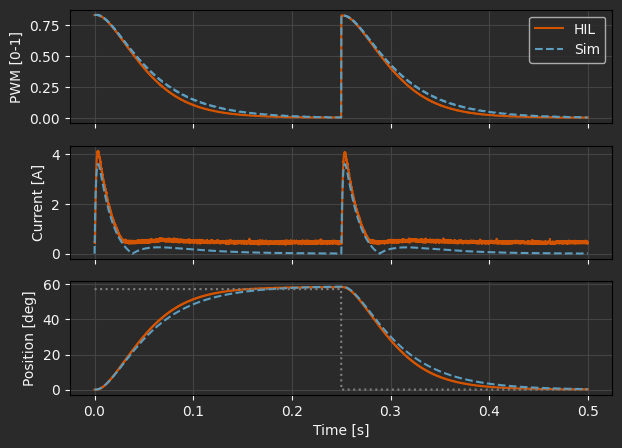

In [26]:
hil_data = np.loadtxt("data/hil_data.csv", delimiter="\t", skiprows=1)
sim_data = np.loadtxt("data/sim_data.csv", delimiter="\t", skiprows=1)

pos_cmd = np.zeros_like(hil_data[:, 0])
pos_cmd[hil_data[:, 0] <= hil_data[:, 0].max() / 2] = np.degrees(1.0)

fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)

ax[0].plot(hil_data[:, 0], hil_data[:, 1], label="HIL")
ax[0].plot(sim_data[:, 0], sim_data[:, 1], "--", label="Sim")
ax[0].set_ylabel("PWM [0-1]")
ax[0].grid()
ax[0].legend()

ax[1].plot(hil_data[:, 0], hil_data[:, 3])
ax[1].plot(sim_data[:, 0], sim_data[:, 3], "--")
ax[1].set_ylabel("Current [A]")
ax[1].grid()

ax[2].plot(hil_data[:, 0], hil_data[:, 4])
ax[2].plot(sim_data[:, 0], sim_data[:, 4], "--")
ax[2].plot(hil_data[:, 0], pos_cmd, ":", color="gray", label="Command")
ax[2].set_ylabel("Position [deg]")
ax[2].grid()

ax[-1].set_xlabel("Time [s]")

plt.show()

The correspondence is generally good, indicating that we're not running into any major problems with latency, A/D sampling noise, embedded implementation bugs, or board configuration issues.

One feature of the results that could be worth examining in more detail is that the simulated current has a slight sign change around 50 ms and again around 300 ms (note that the measured current is in absolute value, so these show up as discontinuities).
There is a slight corresponding discrepancy between the simulated and predicted position following this current deviation.

Besides the sign change, it appears that _any_ small values of current get clipped to something like 250 mA.
Is this a feature of the A/D or D/A conversion?  Data types in the embedded implementation?
Since we're not using the current for feedback in this case, this may not be a problem - it depends on how accurate your HIL model needs to be.
For our purposes here, we'll say this is good enough and move on.


### Case study: cascaded control failure

To better understand the advantages of this kind of incremental testing protocol (continuous time simulation, then full simulated discrete logic, then HIL testing, then deployment), here's a quick anecdote to help illustrate the value.

This example uses a simple PI feedback controller, but the first iteration of this series was based on a more complicated cascaded control approach using an inner current control loop nested in an outer position control loop.
This incorporates the additional sensor information from the current sense output, and could in principle lead to improved controller performance.
The control laws for both loops were designed with internal model control (IMC), an approach that uses approximate inversion of the plant models to develop combined feedforward/feedback laws.

The main reason for taking this more complicated approach to controller design was to illustrate how you can seamlessly go from high-level tools like the Python Control Systems Library and model-based controller synthesis to deployment-ready C code.

The cascaded IMC controllers had excellent theoretical performance and stability margins, and matched the theoretical behavior in the simulation.
However, during HIL testing it _completely failed_.
Repeating with the actual motor hardware confirmed this failure.

Was this due to a high sensitivity to small digital latency in the current control loop?
Was it related to the deviations from ideal current values that we saw in the PI test?
Or did this indicate some bug in the embedded controller implementation?

What we can say with a high degree of certainty is that it was some feature of the hardware controller, since that's the only thing that changed from the simulations.
In this case, we just switched to a PI control loop, which proved totally adequate for this tutorial.
But if this was an application where a higher-performance controller _was_ worth the development effort, the HIL testing would be a valuable way to narrow the scope of debugging compared to iterating between simulation and deployment to the physical motor.

## Conclusions

The key enabler for this rapid, low-cost HIL testing stage is the C code generation for the plant model along with the controller logic.
This makes it seamless to calibrate the plant model using parameter estimation, simulate the controller performance, and then perform more rigorous HIL testing, _all with the exact same physics model and control algorithm_.

For this simple case we just used a second STM32 board to run the plant, but there are a number of ways to extend this approach to more complex systems.
For instance, first-order refinements to this process might include:

* Switching from slow USB data transfer to Ethernet communication
* Data logging for both the controller and plant
* Configuring automated HIL testing as part of a CI/CD pipeline
* Distributed plant models (e.g. expensive or parallelized simulation on a workstation, then real-time simulation components on bare metal)

But for now, we'll consider this step of the development workflow done.
In the next and final part of this series, we'll simply swap the leads from the plant board to the physical motor and see how well our controller works in reality!